# ML модели временных рядов с библиотекой TSAI

В этом ноутбуке мы тестируем топовые модели deep learning для временных рядов из библиотеки TSAI с использованием walk-forward валидации.

## Модели для тестирования:
1. **InceptionTime** - сверточная сеть с модулями Inception
2. **ResNet** - остаточная сеть для временных рядов  
3. **ROCKET** - рандомные сверточные ядра
4. **MiniRocket** - упрощенная версия ROCKET
5. **TST** - Time Series Transformer
6. **PatchTST** - патч-базированный трансформер

## Методология:
- **Walk-forward валидация**: модель переобучается после каждого прогноза
- **Разбивка данных**: 95% обучение, 5% тест
- **Горизонт прогноза**: 1 шаг вперед


In [ ]:
!pip install virtualenv

In [ ]:
import virtualenv
import subprocess
import os
import sys

notebook_name = "tsai"
virtualenv.cli_run(["venvs/" + notebook_name, "--no-download"])

venv_dir = "venvs/" + notebook_name
python_path = os.path.join(venv_dir, "bin", "python")
display_name = "Python (" + notebook_name + ")"
kernel_name = notebook_name

# Установка ipykernel в venv
subprocess.check_call([os.path.join(venv_dir, "bin", "pip"), "install", "ipykernel"])

# Регистрация ядра
subprocess.check_call([
    python_path, "-m", "ipykernel", "install",
    "--user",
    "--name", kernel_name,
    "--display-name", display_name
])

In [1]:
import sys
print(sys.executable)

/workspace/predictors/univariate/venvs/tsai/bin/python


In [ ]:
import subprocess
import os
import sys

# Путь к pip в активном ядре
pip_path = os.path.join(sys.prefix, "bin", "pip")

# Установка
subprocess.check_call([pip_path, "install", "tsai", "torch", "matplotlib", "scikit-learn", "pandas", "numpy", "seaborn", "fasttransform", "fastcore==1.7.29", "fastai==2.7.19"])

In [13]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# TSAI импорты
from tsai.all import *
from fastai.losses import MSELossFlat

# Установим читаемый формат для вывода чисел
pd.options.display.float_format = '{:.4f}'.format

print("Библиотеки загружены успешно!")

Библиотеки загружены успешно!


In [2]:
def directional_accuracy(actual, predicted):
    """
    Calculates Directional Accuracy by comparing each predicted value's
    direction with the actual value's direction.
    """
    actual_direction = np.sign(actual[1:] - actual[:-1])  # Direction of actual values
    predicted_direction = np.sign(predicted[1:] - predicted[:-1])  # Direction of predictions

    # Calculate accuracy
    return np.mean(actual_direction == predicted_direction) * 100


def smape_score(y_true, y_pred):
    """Симметричная средняя абсолютная процентная ошибка"""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Загрузка данных

In [3]:
def load_series_map(series_dir="../../data/series"):
    """Загружает временные ряды из CSV файлов"""
    series_map = {}
    series_path = Path(series_dir)
    if not series_path.exists():
        raise FileNotFoundError(f"Папка не найдена: {series_dir}")
    
    for csv_file in series_path.glob("*.csv"):
        ticker = csv_file.stem.upper()
        df = pd.read_csv(csv_file)
        if "timestamp" not in df.columns or "close" not in df.columns:
            raise ValueError(f"{csv_file.name} не содержит 'timestamp' или 'close'")
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
        df = df[["timestamp", "close"]].sort_values("timestamp").reset_index(drop=True)
        series_map[ticker] = df
    
    return series_map

# Загружаем данные
series_map = load_series_map("../../data/series")
print(f"Загружено {len(series_map)} временных рядов:")
for ticker, df in series_map.items():
    print(f"  {ticker}: {len(df)} точек данных")

Загружено 10 временных рядов:
  AFLT: 2375 точек данных
  LKOH: 2375 точек данных
  MOEX: 2375 точек данных
  NVTK: 2373 точек данных
  PIKK: 2375 точек данных
  SBER: 2375 точек данных
  VKCO: 1197 точек данных
  VTBR: 1722 точек данных
  X5: 1499 точек данных
  YDEX: 2339 точек данных


In [56]:
def create_sequences(data, seq_len=30, horizon=1):
    """
    Создает последовательности для обучения моделей TSAI
    
    Args:
        data: массив значений временного ряда
        seq_len: длина входной последовательности  
        horizon: горизонт прогноза
    
    Returns:
        X, y: входные последовательности и целевые значения
    """
    X, y = [], []
    for i in range(len(data) - seq_len - horizon + 1):
        X.append(data[i:(i + seq_len)])
        y.append(data[i + seq_len:i + seq_len + horizon])
    
    return np.array(X), np.array(y)

from sklearn.preprocessing import StandardScaler
import numpy as np

def prepare_tsai_data(series_map, test_ratio=0.05, seq_len=30):
    """
    Подготавливает данные для TSAI с разбивкой 95%/5%
    и сохраняет и «сырые» цены для обратного преобразования.
    """
    prepared_data = {}
    
    for ticker, df in series_map.items():
        # 1) Сырые цены
        raw_full = df['close'].values.astype(float)
        
        # 2) Масштабирование
        scaler    = StandardScaler()
        scaled    = scaler.fit_transform(raw_full.reshape(-1,1)).flatten()
        
        # 3) Сплит 95% / 5%
        split_idx = int(len(scaled) * (1 - test_ratio))
        train_s   = scaled[:split_idx]
        test_s    = scaled[split_idx:]
        raw_test  = raw_full[split_idx:]      # <--- вот он, ваш missing key
        
        # 4) Последовательности для обучения
        X_train, y_train = create_sequences(train_s, seq_len)
        
        prepared_data[ticker] = {
            'full_data':  scaled,
            'raw_full':   raw_full,
            'train_data': train_s,
            'test_data':  test_s,
            'raw_test':   raw_test,      # <--- добавили
            'scaler':     scaler,
            'split_idx':  split_idx,
            'seq_len':    seq_len
        }
        print(f"{ticker}: splitted at {split_idx}, raw_test.shape = {raw_test.shape}")
    return prepared_data

# Подготавливаем данные для TSAI
prepared_data = prepare_tsai_data(series_map, test_ratio=0.05, seq_len=30)
print(f"\nДанные подготовлены для {len(prepared_data)} тикеров")

AFLT: splitted at 2256, raw_test.shape = (119,)
LKOH: splitted at 2256, raw_test.shape = (119,)
MOEX: splitted at 2256, raw_test.shape = (119,)
NVTK: splitted at 2254, raw_test.shape = (119,)
PIKK: splitted at 2256, raw_test.shape = (119,)
SBER: splitted at 2256, raw_test.shape = (119,)
VKCO: splitted at 1137, raw_test.shape = (60,)
VTBR: splitted at 1635, raw_test.shape = (87,)
X5: splitted at 1424, raw_test.shape = (75,)
YDEX: splitted at 2222, raw_test.shape = (117,)

Данные подготовлены для 10 тикеров


## Тест

In [57]:
from sklearn.preprocessing import StandardScaler

def prepare_tsai_data(series_map, test_ratio=0.05, seq_len=30):
    """
    Подготавливает данные для TSAI с разбивкой 95%/5%
    
    Возвращает в ticker_data не только нормализованные train/test, но
    и «сырые» цены raw_full, raw_test для обратного преобразования.
    """
    prepared_data = {}
    
    for ticker, df in series_map.items():
        raw_values    = df['close'].values.astype(float)
        scaler        = StandardScaler()
        scaled_values = scaler.fit_transform(raw_values.reshape(-1, 1)).flatten()

        split_idx     = int(len(scaled_values) * (1 - test_ratio))
        train_data    = scaled_values[:split_idx]
        test_data     = scaled_values[split_idx:]
        
        # Сохраним и «сырые» цены для теста
        raw_test      = raw_values[split_idx:]
        
        # Последовательности для обучения
        X_train, y_train = create_sequences(train_data, seq_len)
        
        prepared_data[ticker] = {
            'full_data':   scaled_values,
            'raw_full':    raw_values,
            'train_data':  train_data,
            'test_data':   test_data,
            'raw_test':    raw_test,
            'X_train':     X_train,
            'y_train':     y_train,
            'scaler':      scaler,
            'split_idx':   split_idx,
            'seq_len':     seq_len
        }
        print(f"{ticker}: train={len(train_data)}, test={len(test_data)}, sequences={len(X_train)}")
    
    return prepared_data

In [169]:
from tsai.learner          import Learner
from fastai.losses         import MSELossFlat
from tsai.metrics          import mae, rmse
from sklearn.metrics       import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

def walk_forward_tsai_fast(
    ticker, ticker_data,
    model_class, model_kwargs=None,
    epochs=20, bs_train=32, bs_valid=128, lr=1e-3
):
    """
    1) Train once on train_data via create_sequences()
    2) Walk-forward predict raw prices without retraining
    """
    print(f"\n=== {ticker}: {model_class.__name__} fast Walk-forward ===")

    # --- извлекаем из ticker_data ---
    scaled_full  = np.array(ticker_data['full_data'], dtype=float)
    scaled_test  = np.array(ticker_data['test_data'], dtype=float)
    raw_test     = np.array(ticker_data['raw_test'],   dtype=float)
    split        = ticker_data['split_idx']
    seq_len      = ticker_data['seq_len']
    scaler       = ticker_data['scaler']

    # 1) Подготовка train
    train_s = scaled_full[:split]  # уже 1D
    
    X_train, y_train = create_sequences(train_s, seq_len)
    X_train = X_train.reshape(len(X_train), 1, seq_len)
    y_train = y_train.flatten()

    idxs   = np.arange(len(X_train))
    splits = RandomSplitter()(idxs)
    dsets  = TSDatasets(X_train, y_train, splits=splits, tfms=None, inplace=True)
    dls    = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs_train, bs_valid])

    # 2) Обучение один раз
    model = model_class(dls.vars, dls.c, dls.len, **(model_kwargs or {}))
    learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=[mae, rmse])
    t0 = time.time()
    with learn.no_bar(), learn.no_logging():
        learn.fit_one_cycle(epochs, lr_max=lr)
    train_time = time.time() - t0
    print(f" Trained in {train_time:.2f}s")

    # 3) Walk-forward прогноз raw цен
    preds_raw, times = [], []
    history_s = train_s.copy()

    for i in range(len(scaled_test)):
        # добавляем в историю предыдущий реальный raw → масштабируем
        if i > 0:
            prev = raw_test[i-1]
            history_s = np.append(history_s, scaler.transform([[prev]])[0,0])

        if len(history_s) < seq_len:
            continue

        seq_in = history_s[-seq_len:].reshape(1,1,seq_len)
        t1     = time.time()
        with torch.no_grad():
            pred_s = model(torch.tensor(seq_in, dtype=torch.float32)) \
                          .cpu().numpy().ravel()[0]
        dt = time.time() - t1

        # обратное преобразование в цену
        pred_price = scaler.inverse_transform([[pred_s]])[0,0]
        preds_raw.append(pred_price)
        times.append(dt)

    # 4) Метрики на реальных ценах
    preds_raw = np.array(preds_raw)
    actuals   = raw_test[:len(preds_raw)]

    mae_v    = mean_absolute_error(actuals, preds_raw)
    rmse_v   = mean_squared_error(actuals, preds_raw)
    mape_v   = mean_absolute_percentage_error(actuals, preds_raw) * 100
    da_v     = directional_accuracy(actuals, preds_raw)
    avg_pred = np.mean(times)
    eff_step = train_time + avg_pred

    print(f"\nResults for {ticker}:")
    print(f" MAE:   {mae_v:.4f}")
    print(f" MAPE:  {mape_v:.2f}%")
    print(f" RMSE:  {rmse_v:.4f}")
    print(f" DA:    {da_v:.2f}%")
    print(f" Time:  train={train_time:.2f}s, pred_avg={avg_pred:.4f}s, eff_step={eff_step:.4f}s")

    return {
        'actuals':    actuals,
        'predictions': preds_raw,
        'times':       times,
        'metrics': {
            'MAE':            mae_v,
            'MAPE (%)':       mape_v,
            'RMSE':           rmse_v,
            'DA (%)':         da_v,
            'Train Time (s)': train_time,
            'Avg Pred Time':  avg_pred,
            'Eff Time/step':  eff_step
        }
    }

In [170]:
# Правильная конфигурация моделей TSAI
models_config = {
    # 'FCN': {
    #     'class': FCN,
    #     'kwargs': {
    #         # у FCN обычно нет настраиваемых параметров кроме output_chunk_length
    #     },
    #     'epochs': 20
    # },
    # 'ResNet': {
    #     'class': ResNet,
    #     'kwargs': {
    #         # ResNet берёт все параметры по умолчанию
    #     },
    #     'epochs': 20
    # },
    'XceptionTime': {
        'class': XceptionTime,
        'kwargs': {
            'nb_filters': 32,    # число фильтров в depthwise и pointwise сверточных слоях
        },
        'epochs': 1
    },
    'ROCKET': {
        'class': ROCKET,
        'kwargs': {
            'kss':       [7, 9, 11, 13],# <- вот он, список «окошек»
            'device':    'cpu',         # или 'cuda' если GPU
        },
        'epochs': 1   # ROCKET быстро обучается, не нужен большой EPOCHS
    },
    'MiniRocket': {
        'class': MiniRocket,
        'kwargs': {
            'kss':       [7, 9, 11, 13],# <- вот он, список «окошек»
            'device':    'cpu',         # или 'cuda' если GPU
        },
        'epochs': 1
    },
    'TCN': {
        'class': TCN,
        'kwargs': {
            'kernels': [3, 5, 7],  # различные размеры ядер
            'dilations': [1, 2, 4],# dilations для ресептивного поля
            'num_filters': 32,
        },
        'epochs': 1
    },
    # 'InceptionTime': {
    #     'class': InceptionTime,
    #     'kwargs': {'nb_filters': 32},
    #     'epochs': 20
    # },
    # 'XCM': {
    #     'class': XCM,
    #     'kwargs': {
    #         'kernels': [64, 64],   # кол-во фильтров на каждой ветке
    #         'dilations': [1, 2],   # дилатации для двух веток
    #         'stride': 1
    #     },
    #     'epochs': 20
    # },
    # 'gMLP': {
    #     'class': gMLP,
    #     'kwargs': {
    #         'd_model': 64,         # ширина эмбеддинга
    #         'd_ffn': 128,          # размер FFN внутри блока
    #     },
    #     'epochs': 20
    # },
    # # 'TSPerceiver': {
    # #     'class': TSPerceiver,
    # #     'kwargs': {
    # #     },
    # #     'epochs': 3
    # # },
    # 'TSSequencerPlus': {
    #     'class': TSSequencerPlus,
    #     'kwargs': {
    #         'd_model': 64,         # размер токен-эмбеддинга
    #         'depth': 4             # число MLP-блоков
    #     },
    #     'epochs': 20
    # },
}

print("Конфигурация моделей TSAI:")
for name, config in models_config.items():
    print(f"  {name}: {config['class'].__name__} с {config['epochs']} эпохами")

Конфигурация моделей TSAI:
  XceptionTime: XceptionTime с 1 эпохами
  ROCKET: ROCKET с 1 эпохами
  MiniRocket: MiniRocket с 1 эпохами
  TCN: TCN с 1 эпохами


In [171]:
# Основной пайплайн walk-forward валидации для TSAI
all_results = {}

# Выбираем первые 2 тикера для тестирования (чтобы не ждать слишком долго)
test_tickers = list(prepared_data.keys())[:1]
print(f"Тестируем модели на тикерах: {test_tickers}")

for ticker in test_tickers:
    print(f"\n{'='*80}")
    print(f"ОБРАБОТКА ТИКЕРА: {ticker}")
    print(f"{'='*80}")
    
    ticker_data = prepared_data[ticker]
    ticker_results = {}
    
    for model_name, model_config in models_config.items():
        #try:
            print(f"\n--- Модель: {model_name} ---")
            
            # Выполняем walk-forward валидацию
            result = walk_forward_tsai_fast(
                ticker=ticker,
                ticker_data=ticker_data,
                model_class=model_config['class'],
                model_kwargs=model_config['kwargs'],
                epochs=model_config['epochs']
            )
            
            ticker_results[model_name] = result
            
        # except Exception as e:
        #     print(f"\n!!! ОШИБКА с моделью {model_name} для {ticker}: {e}")
        #     ticker_results[model_name] = {
        #         'metrics': {
        #             'MAE': np.nan,
        #             'MAPE (%)': np.nan,
        #             'RMSE': np.nan,
        #             'DA (%)': np.nan,
        #             'Avg Time (s)': np.nan
        #         }
        #     }
    
    all_results[ticker] = ticker_results

print(f"\n{'='*80}")
print("ОБРАБОТКА ЗАВЕРШЕНА")
print(f"{'='*80}")

Тестируем модели на тикерах: ['AFLT']

ОБРАБОТКА ТИКЕРА: AFLT

--- Модель: XceptionTime ---

=== AFLT: XceptionTime fast Walk-forward ===
 Trained in 7.93s

Results for AFLT:
 MAE:   19.6499
 MAPE:  32.46%
 RMSE:  460.3849
 DA:    2.54%
 Time:  train=7.93s, pred_avg=0.0062s, eff_step=7.9400s

--- Модель: ROCKET ---

=== AFLT: ROCKET fast Walk-forward ===


ValueError: 'a' cannot be empty unless no samples are taken


ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ TSAI WALK-FORWARD ВАЛИДАЦИИ

Детальные результаты по тикерам и моделям:


,Ticker,Model,MAE,MAPE (%),RMSE,DA (%),Avg Time (s)
0,AFLT,InceptionTime,1.7386,2.7495,4.6791,45.7627,55.8059
1,AFLT,XCM,2.4036,3.6768,9.1996,44.0678,9.8882
2,AFLT,gMLP,1.3484,2.0914,3.3571,44.9153,28.6919
3,AFLT,TSSequencerPlus,2.1935,3.3830,7.0599,48.3051,37.8128
4,LKOH,InceptionTime,94.4004,1.3535,16996.3993,47.4576,57.3148
5,LKOH,XCM,126.4268,1.8263,28720.0554,47.4576,9.7753
6,LKOH,gMLP,82.4048,1.1844,14908.8306,45.7627,29.1566
7,LKOH,TSSequencerPlus,109.3138,1.5860,22112.8916,46.6102,40.7404
8,MOEX,InceptionTime,3.5030,1.7165,19.1152,44.0678,57.8952
9,MOEX,XCM,5.7065,2.7952,50.8730,47.4576,10.4953



Средние показатели по моделям:


,MAE,MAPE (%),RMSE,DA (%),Avg Time (s)
Model,,,,,
InceptionTime,29.9412,2.6728,3553.1064,46.9613,49.7616
TSSequencerPlus,32.0874,2.8069,3894.6002,47.3624,34.1919
XCM,40.5119,3.6174,6218.6047,50.6019,8.8246
gMLP,25.2700,2.1903,2812.8679,45.5138,26.0191


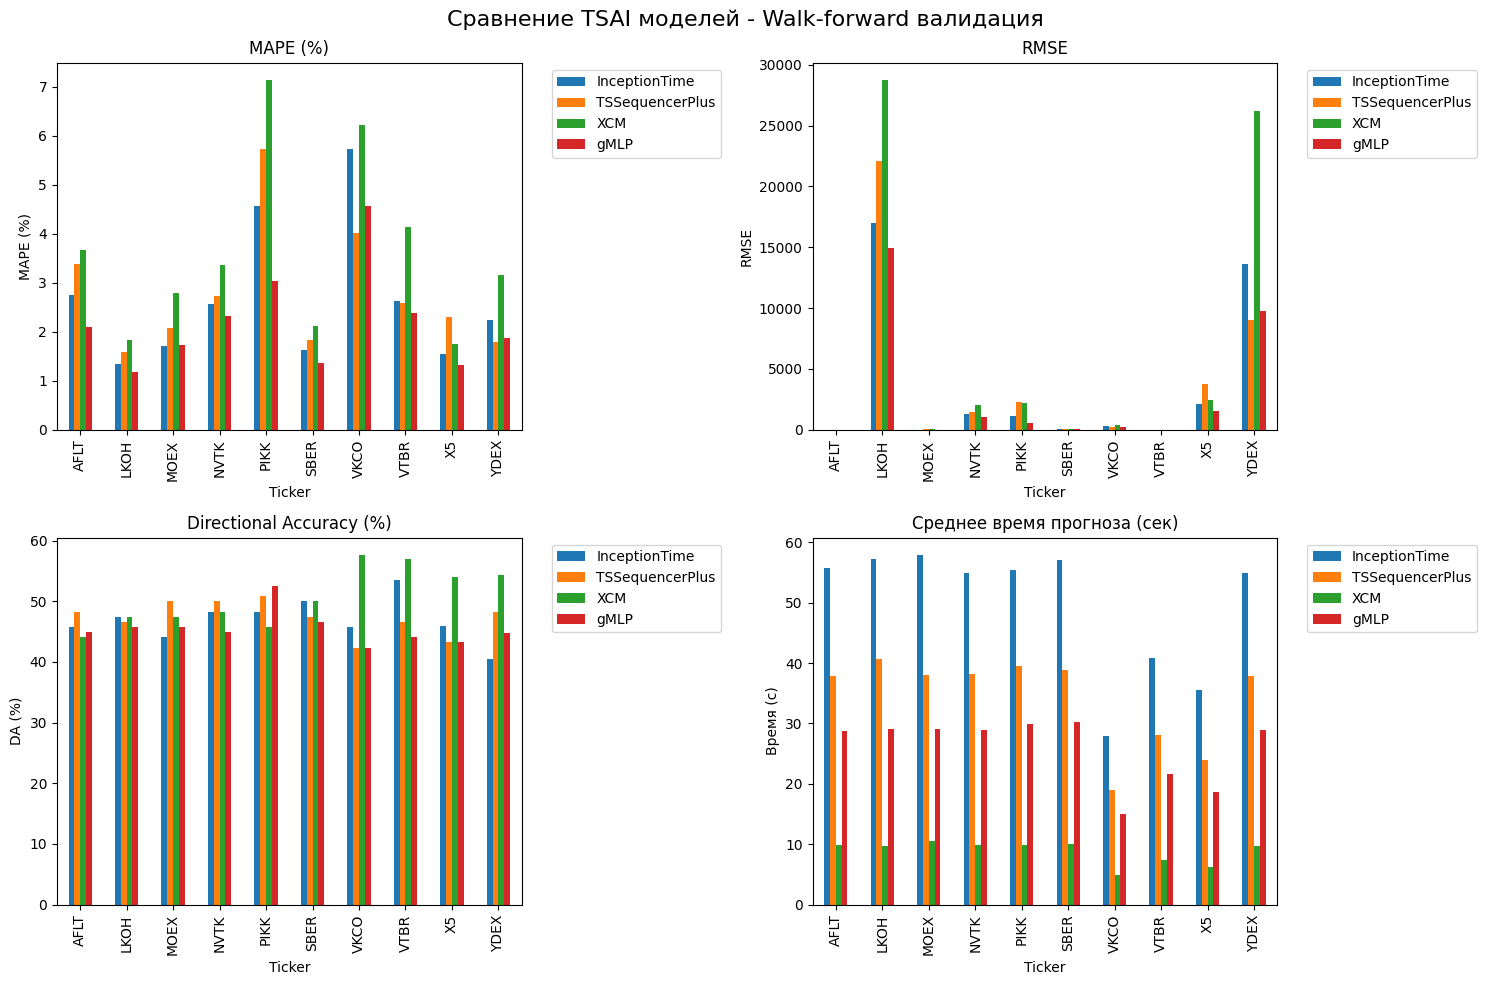

In [100]:
# Создание итоговой таблицы результатов TSAI
summary_data = []

for ticker, ticker_results in all_results.items():
    for model_name, result in ticker_results.items():
        metrics = result['metrics']
        summary_data.append({
            'Ticker': ticker,
            'Model': model_name,
            'MAE': metrics['MAE'],
            'MAPE (%)': metrics['MAPE (%)'],
            'RMSE': metrics['RMSE'],
            'DA (%)': metrics['DA (%)'],
            'Avg Time (s)': metrics['Eff Time/step']
        })

# Создаем DataFrame
summary_df = pd.DataFrame(summary_data)

# Сводная таблица по моделям
if len(summary_df) > 0:
    model_summary = summary_df.groupby('Model').agg({
        'MAE': 'mean',
        'MAPE (%)': 'mean',
        'RMSE': 'mean',
        'DA (%)': 'mean',
        'Avg Time (s)': 'mean'
    }).round(4)
    
    print("\n" + "="*80)
    print("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ TSAI WALK-FORWARD ВАЛИДАЦИИ")
    print("="*80)
    print("\nДетальные результаты по тикерам и моделям:")
    display(summary_df.round(4))
    
    print("\nСредние показатели по моделям:")
    display(model_summary)
    
    # Визуализация результатов
    if len(summary_df) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Сравнение TSAI моделей - Walk-forward валидация', fontsize=16)
        
        # MAPE
        summary_df_clean = summary_df.dropna()
        if len(summary_df_clean) > 0:
            pivot_mape = summary_df_clean.pivot(index='Ticker', columns='Model', values='MAPE (%)')
            if not pivot_mape.empty:
                pivot_mape.plot(kind='bar', ax=axes[0,0])
                axes[0,0].set_title('MAPE (%)')
                axes[0,0].set_ylabel('MAPE (%)')
                axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # RMSE
            pivot_rmse = summary_df_clean.pivot(index='Ticker', columns='Model', values='RMSE')
            if not pivot_rmse.empty:
                pivot_rmse.plot(kind='bar', ax=axes[0,1])
                axes[0,1].set_title('RMSE')
                axes[0,1].set_ylabel('RMSE')
                axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # DA
            pivot_da = summary_df_clean.pivot(index='Ticker', columns='Model', values='DA (%)')
            if not pivot_da.empty:
                pivot_da.plot(kind='bar', ax=axes[1,0])
                axes[1,0].set_title('Directional Accuracy (%)')
                axes[1,0].set_ylabel('DA (%)')
                axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # Time
            pivot_time = summary_df_clean.pivot(index='Ticker', columns='Model', values='Avg Time (s)')
            if not pivot_time.empty:
                pivot_time.plot(kind='bar', ax=axes[1,1])
                axes[1,1].set_title('Среднее время прогноза (сек)')
                axes[1,1].set_ylabel('Время (с)')
                axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
else:
    print("Нет данных для отображения")


ВИЗУАЛИЗАЦИЯ ПРОГНОЗОВ TSAI


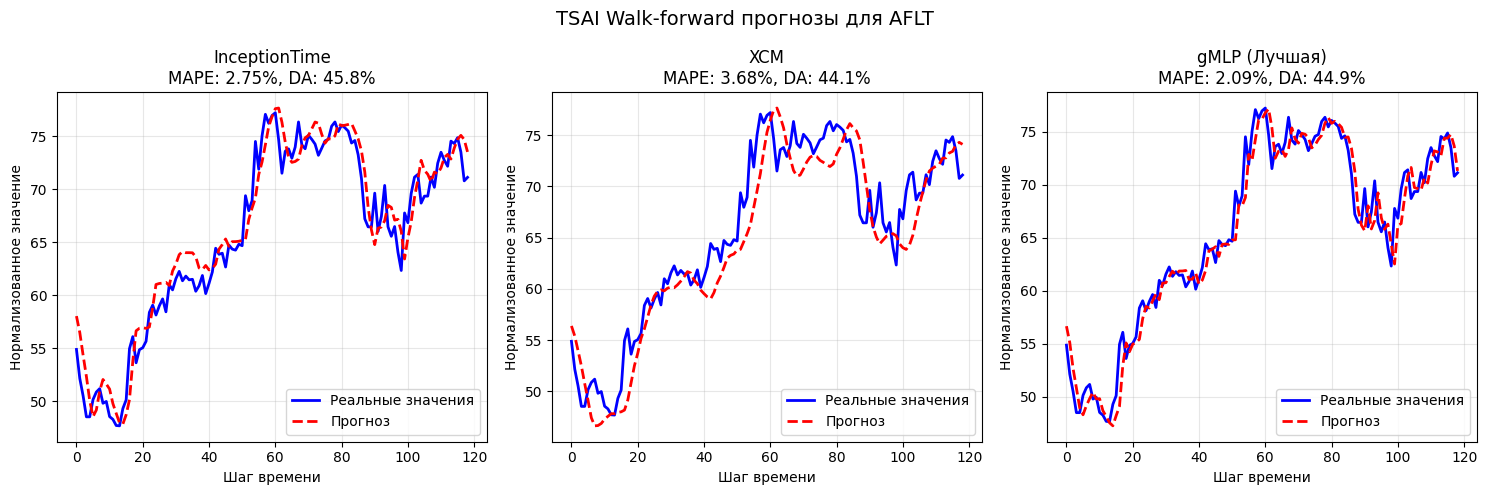

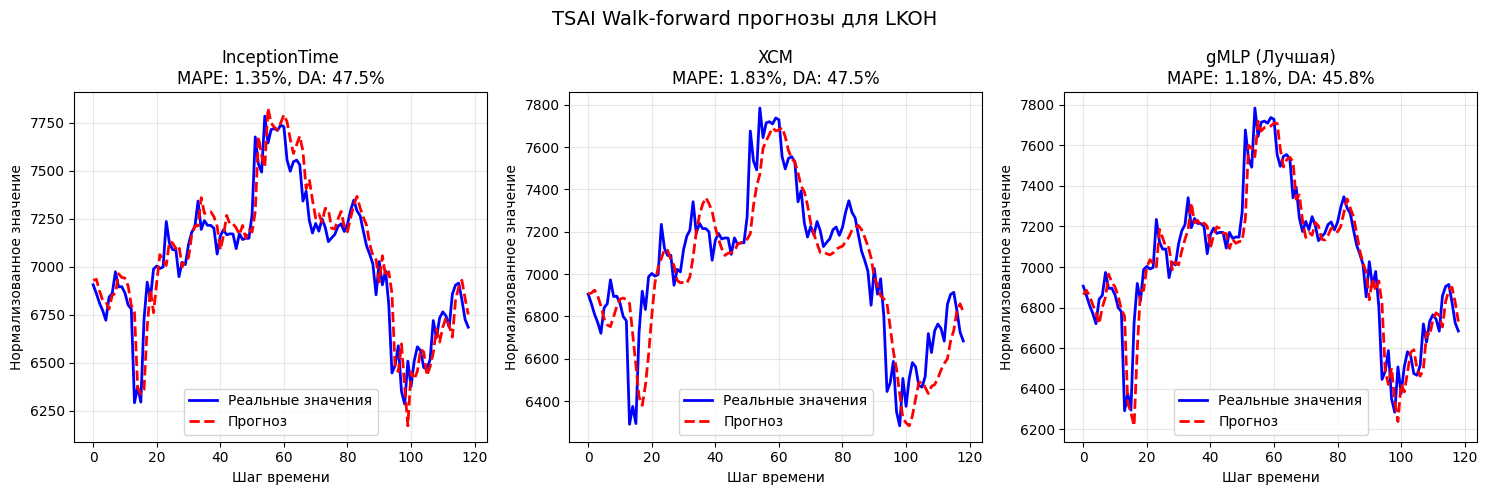

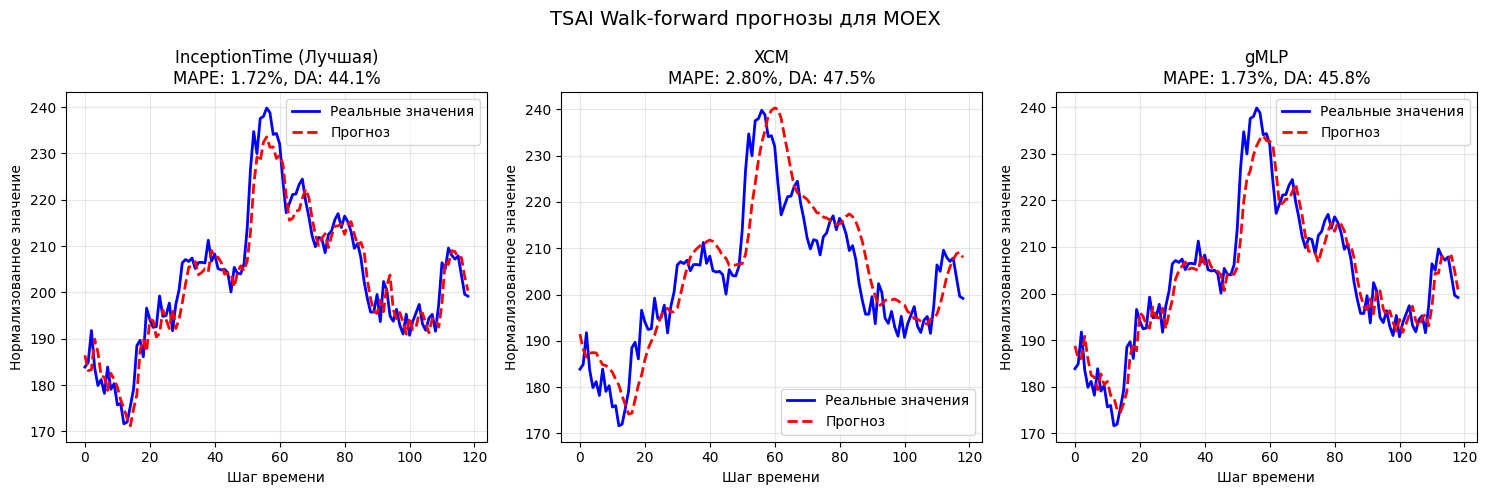

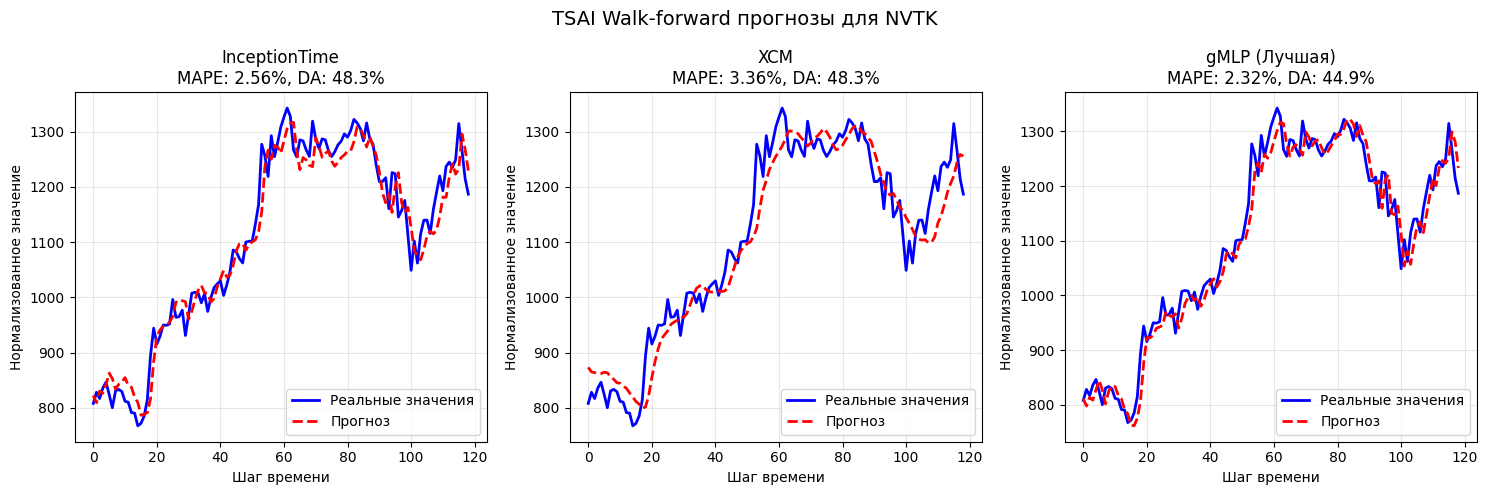

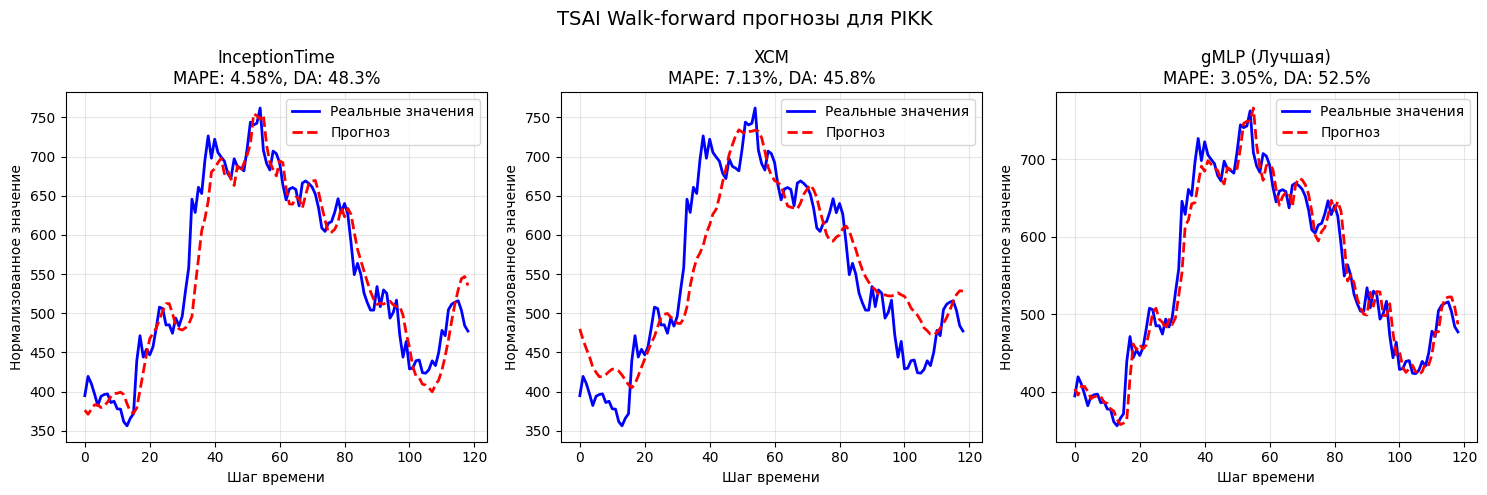

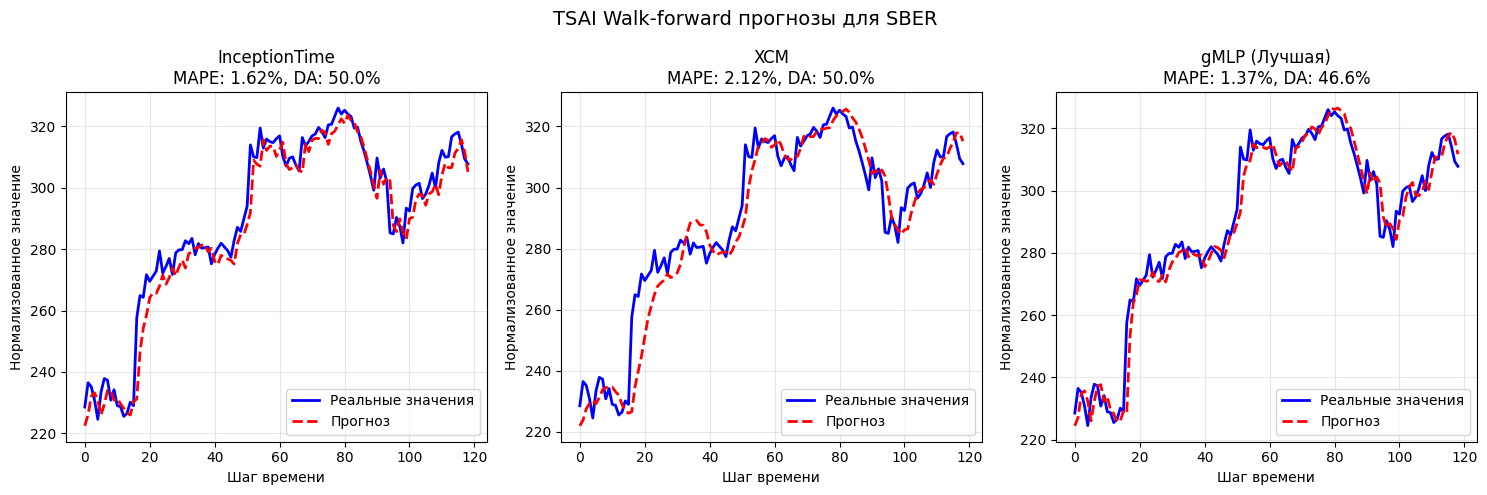

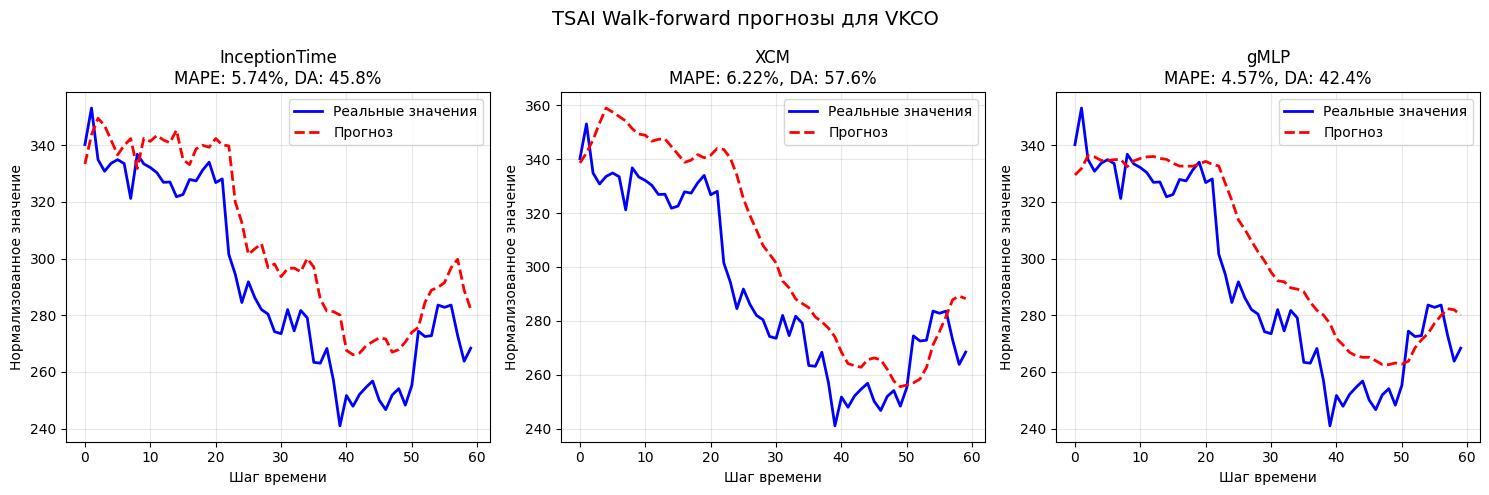

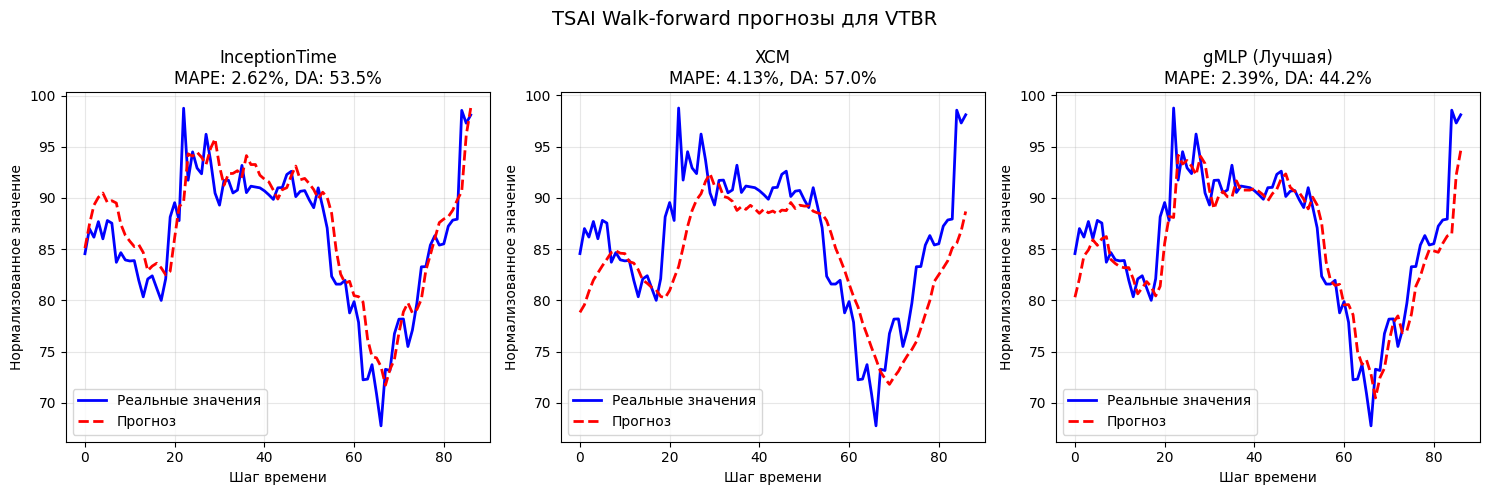

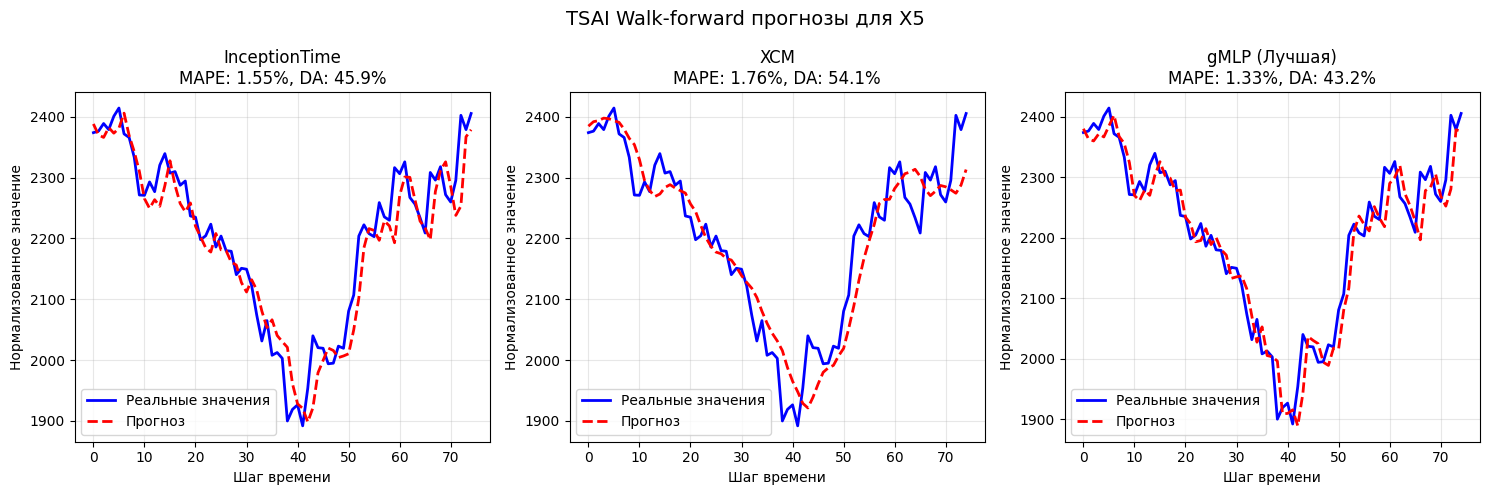

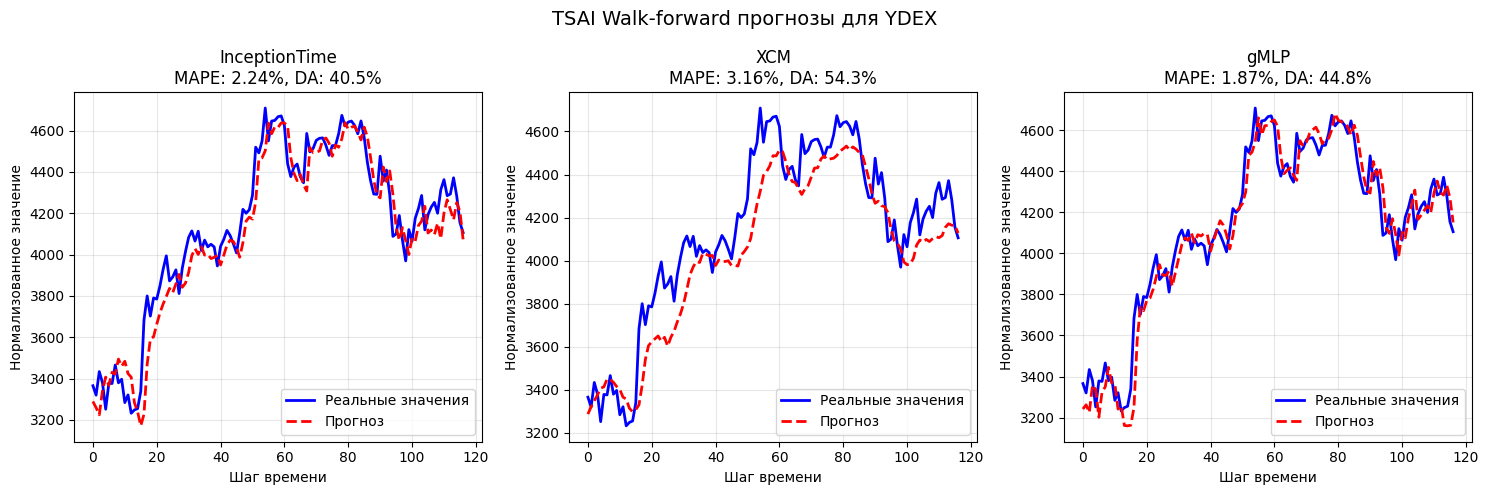

In [101]:
# Визуализация прогнозов TSAI моделей
def plot_tsai_forecasts(ticker, ticker_results, ticker_data):
    """Построение графиков прогнозов TSAI для одного тикера"""
    
    # Находим лучшую модель по MAPE
    best_model = None
    best_mape = float('inf')
    
    for model_name, result in ticker_results.items():
        if 'metrics' in result and not np.isnan(result['metrics']['MAPE (%)']):
            if result['metrics']['MAPE (%)'] < best_mape:
                best_mape = result['metrics']['MAPE (%)']
                best_model = model_name
    
    if best_model is None:
        print(f"Нет успешных результатов для {ticker}")
        return
    
    # Строим графики для всех успешных моделей
    successful_models = []
    for model_name, result in ticker_results.items():
        if 'predictions' in result and len(result['predictions']) > 0:
            successful_models.append(model_name)
    
    if len(successful_models) == 0:
        print(f"Нет данных для построения графиков для {ticker}")
        return
    
    n_models = min(len(successful_models), 3)  # Показываем максимум 3 модели
    fig, axes = plt.subplots(1, n_models, figsize=(15, 5))
    if n_models == 1:
        axes = [axes]
    
    fig.suptitle(f'TSAI Walk-forward прогнозы для {ticker}', fontsize=14)
    
    for i, model_name in enumerate(successful_models[:n_models]):
        ax = axes[i]
        result = ticker_results[model_name]
        
        # Получаем данные
        predictions = result['predictions']
        actuals = result['actuals']
        
        # Строим график
        time_points = range(len(actuals))
        ax.plot(time_points, actuals, label='Реальные значения', color='blue', linewidth=2)
        ax.plot(time_points, predictions, label='Прогноз', color='red', linestyle='--', linewidth=2)
        
        # Оформление
        metrics = result['metrics']
        title = f"{model_name}"
        if model_name == best_model:
            title += " (Лучшая)"
        title += f"\nMAPE: {metrics['MAPE (%)']:.2f}%, DA: {metrics['DA (%)']:.1f}%"
        
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Шаг времени')
        ax.set_ylabel('Нормализованное значение')
    
    plt.tight_layout()
    plt.show()

# Строим графики для всех тикеров
print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИЯ ПРОГНОЗОВ TSAI")
print("="*80)

for ticker in test_tickers:
    if ticker in all_results:
        plot_tsai_forecasts(ticker, all_results[ticker], prepared_data[ticker])

# Transformer's

In [131]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [138]:
def walk_forward_tsai_transformer(
    ticker, ticker_data,
    model_class, model_kwargs=None,
    epochs=20, bs_train=30, lr=1e-3
):
    """
    1) Train once on all train_data via create_sequences()
    2) Walk‐forward predict raw prices without retraining
    """
    print(f"\n=== {ticker}: {model_class.__name__} fast Walk-forward ===")

    # распаковываем
    scaled_full = np.array(ticker_data['full_data'], dtype=float)
    scaled_test = np.array(ticker_data['test_data'], dtype=float)
    raw_test    = np.array(ticker_data['raw_test'],  dtype=float)
    split       = ticker_data['split_idx']
    seq_len     = ticker_data['seq_len']
    scaler      = ticker_data['scaler']

    # 1) готовим train-последовательности
    train_s = scaled_full[:split]
    X_train, y_train = create_sequences(train_s, seq_len)
    X_train = X_train.astype(np.float32).reshape(-1,1,seq_len)  # (N, C=1, L)
    y_train = y_train.flatten().astype(np.float32)              # (N,)

    # 2) создаём PyTorch DataLoader без валидации
    # 1) Собираем индексы и сплитим без валидации (valid==train)
    idxs   = np.arange(len(X_train))
    splits = (idxs, idxs)  # train_idx == valid_idx
    
    # 2) Создаём TSDatasets и TSDataLoaders
    dsets = TSDatasets(X_train, y_train, splits=splits, tfms=None, inplace=True)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs_train, bs_train])


    # 3) строим и обучаем модель один раз
    # обязательно передаём output_chunk_length=1, чтобы модель вернула скаляр
    kwargs = dict(model_kwargs or {})
    kwargs.update({'output_chunk_length': 1})
    model = model_class(dls.vars, dls.c, dls.len, **kwargs)
    learn = Learner(
        dls,
        model,
        loss_func=nn.MSELoss(),
        metrics=[mae, rmse]
    )
    t0 = time.time()
    with learn.no_bar(), learn.no_logging():
        learn.fit_one_cycle(epochs, lr_max=lr)
    train_time = time.time() - t0
    print(f" Trained in {train_time:.2f}s")

    # 4) walk-forward прогнозы «сырых» цен
    preds, times = [], []
    history_s = train_s.copy()
    for i in range(len(scaled_test)):
        if i>0:
            prev_scaled = scaler.transform([[ raw_test[i-1] ]])[0,0]
            history_s   = np.append(history_s, prev_scaled)
        if len(history_s) < seq_len:
            continue

        seq_in = history_s[-seq_len:].astype(np.float32).reshape(1,1,seq_len)
        t1     = time.time()
        with torch.no_grad():
            pred_s = model(torch.from_numpy(seq_in)).cpu().numpy().ravel()[0]
        times.append(time.time()-t1)
        preds.append(scaler.inverse_transform([[pred_s]])[0,0])

    preds   = np.array(preds)
    actuals = raw_test[:len(preds)]

    # 5) метрики на реальных ценах
    mae_v  = mean_absolute_error(actuals, preds)
    rmse_v = mean_squared_error(actuals, preds, squared=False)
    mape_v = mean_absolute_percentage_error(actuals, preds) * 100
    da_v   = directional_accuracy(actuals, preds)
    avg_dt = np.mean(times)
    eff    = train_time + avg_dt

    print(f"\nResults for {ticker}:")
    print(f" MAE:   {mae_v:.4f}")
    print(f" MAPE:  {mape_v:.2f}%")
    print(f" RMSE:  {rmse_v:.4f}")
    print(f" DA:    {da_v:.2f}%")
    print(f" Time:  train={train_time:.2f}s, pred_avg={avg_dt:.4f}s, eff_step={eff:.4f}s")

    return {
        'actuals':     actuals,
        'predictions': preds,
        'times':       times,
        'metrics': {
            'MAE':            mae_v,
            'MAPE (%)':       mape_v,
            'RMSE':           rmse_v,
            'DA (%)':         da_v,
            'Train Time (s)': train_time,
            'Avg Pred Time':  avg_dt,
            'Eff Time/step':  eff
        }
    }

In [139]:
# Правильная конфигурация моделей TSAI
models_config = {
    # 'GatedTabTransformer': {
    #     'class': GatedTabTransformer,
    #     'kwargs': {
    #         'd_model':      64,
    #         'n_layers':     4,
    #         'n_heads':      4,
    #         'd_ff':         128,
    #     },
    #     'epochs': 20
    # },
    'PatchTST': {
        'class': PatchTST,
        'kwargs': {
            'patch_len': 10,       # длина патча
            'stride': 5,           # шаг между патчами
            'd_model': 64,         # размер эмбеддинга
            'n_heads': 4,          # число голов внимания
        },
        'epochs': 20
    },
}

print("Конфигурация моделей TSAI:")
for name, config in models_config.items():
    print(f"  {name}: {config['class'].__name__} с {config['epochs']} эпохами")

Конфигурация моделей TSAI:
  PatchTST: PatchTST с 20 эпохами


In [140]:
# Основной пайплайн walk-forward валидации для TSAI
all_results = {}

# Выбираем первые 2 тикера для тестирования (чтобы не ждать слишком долго)
test_tickers = list(prepared_data.keys())[:1]
print(f"Тестируем модели на тикерах: {test_tickers}")

for ticker in test_tickers:
    print(f"\n{'='*80}")
    print(f"ОБРАБОТКА ТИКЕРА: {ticker}")
    print(f"{'='*80}")
    
    ticker_data = prepared_data[ticker]
    ticker_results = {}
    
    for model_name, model_config in models_config.items():
        #try:
            print(f"\n--- Модель: {model_name} ---")
            
            # Выполняем walk-forward валидацию
            result = walk_forward_tsai_transformer(
                ticker=ticker,
                ticker_data=ticker_data,
                model_class=model_config['class'],
                model_kwargs=model_config['kwargs'],
                epochs=model_config['epochs']
            )
            
            ticker_results[model_name] = result
            
        # except Exception as e:
        #     print(f"\n!!! ОШИБКА с моделью {model_name} для {ticker}: {e}")
        #     ticker_results[model_name] = {
        #         'metrics': {
        #             'MAE': np.nan,
        #             'MAPE (%)': np.nan,
        #             'RMSE': np.nan,
        #             'DA (%)': np.nan,
        #             'Avg Time (s)': np.nan
        #         }
        #     }
    
    all_results[ticker] = ticker_results

print(f"\n{'='*80}")
print("ОБРАБОТКА ЗАВЕРШЕНА")
print(f"{'='*80}")

Тестируем модели на тикерах: ['AFLT']

ОБРАБОТКА ТИКЕРА: AFLT

--- Модель: PatchTST ---

=== AFLT: PatchTST fast Walk-forward ===


TypeError: PatchTST.__init__() got an unexpected keyword argument 'output_chunk_length'